In [1]:
%matplotlib inline

import os
import sys
import copy
import time
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

# just for presentation
import warnings
warnings.filterwarnings("ignore")

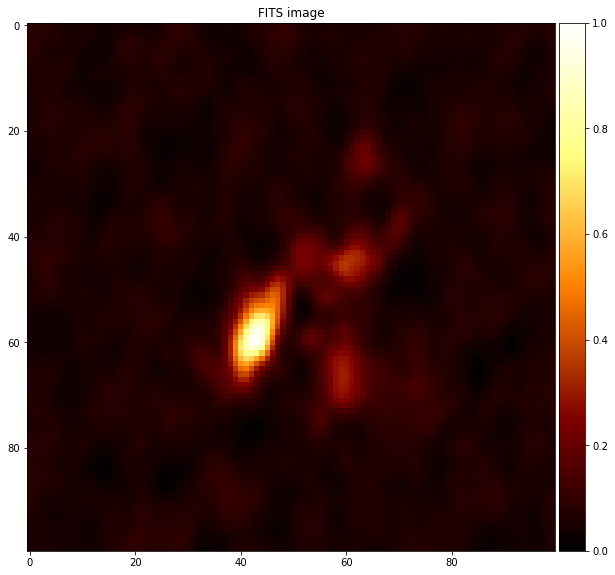

In [2]:
"""
Loading data
"""

fits_path = '../data/images/Orion.cont.image.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [3]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

Widget Javascript not detected.  It may not be installed or enabled properly.


<function graph.thresholded_image_plot>

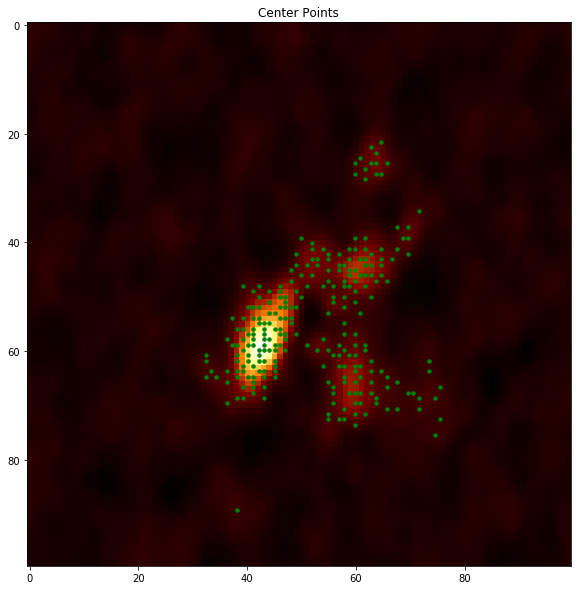

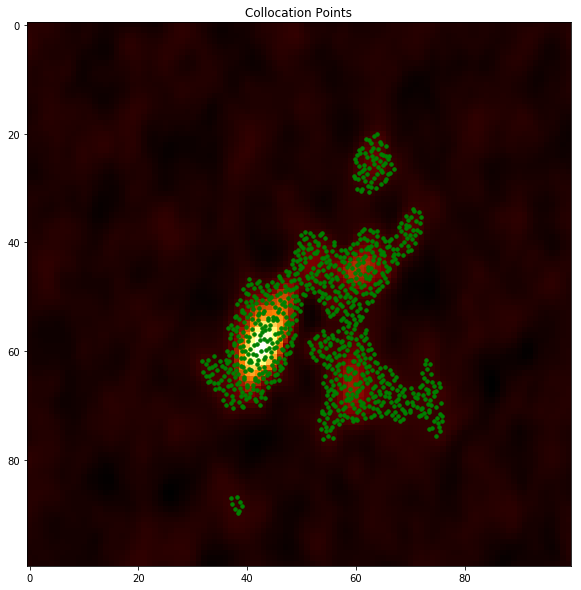

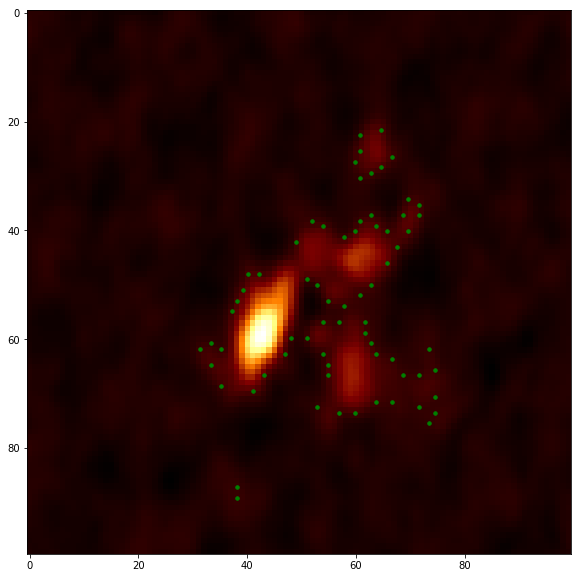

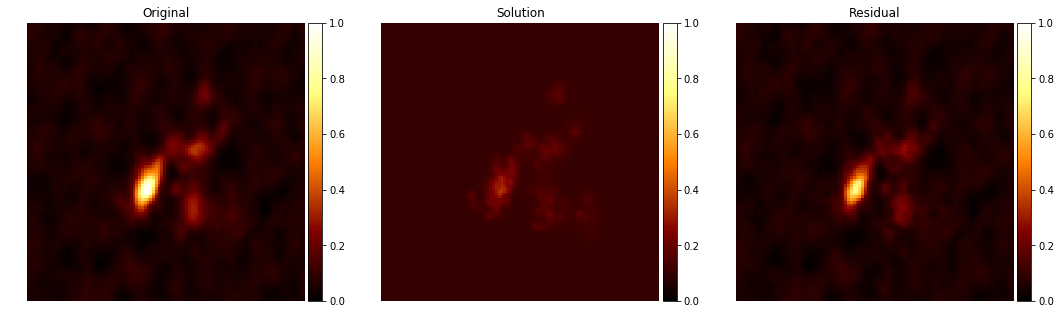

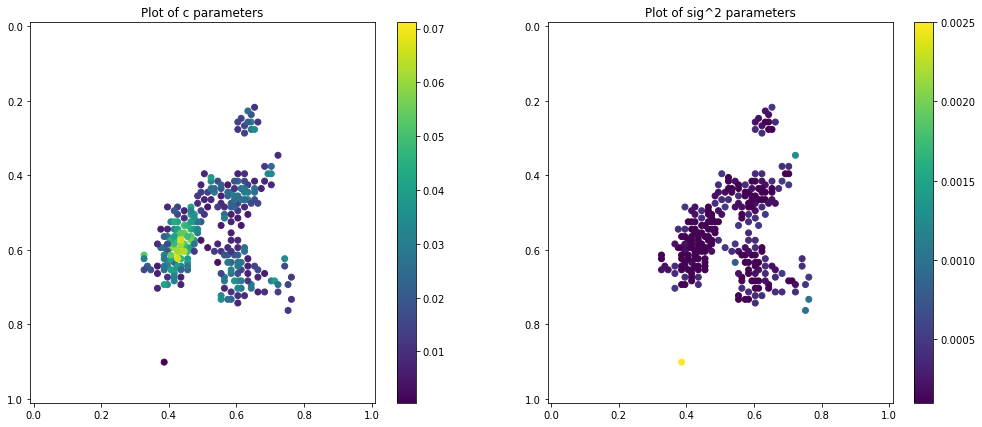

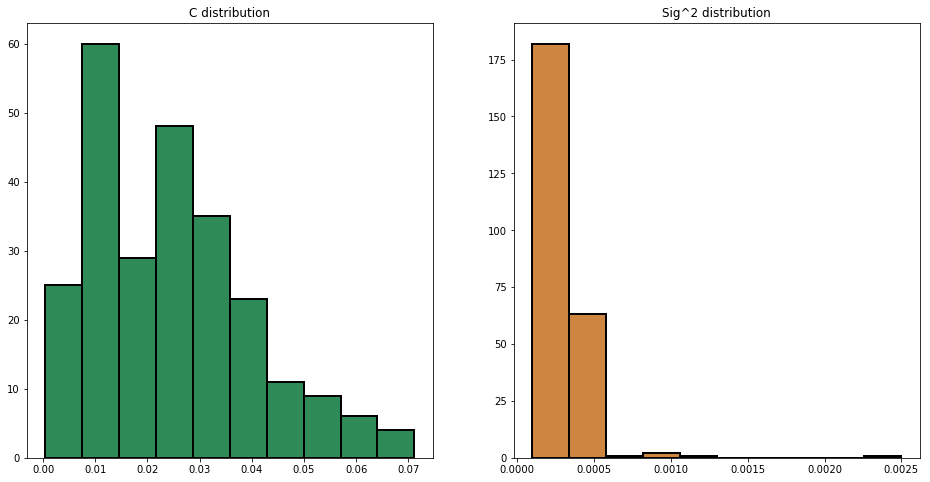

In [ ]:
Nc = 250
Nb = int(0.2* np.sum(boundary_map(data, base_level))) #20% of boundary pixels
Ne = 4*Nc - Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_points_generation(data, base_level, Nb)


# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")


####################################
# Initial parameters estimation
####################################
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)

In [ ]:
nfev = 100*(len(elm01.get_params())+1)
elm_solver(elm01, method='standard', max_nfev=nfev)

### Gradient analyticaly computed

In [17]:
grad1 = elm01.get_gradient()

Max gradient: 26.3377487322


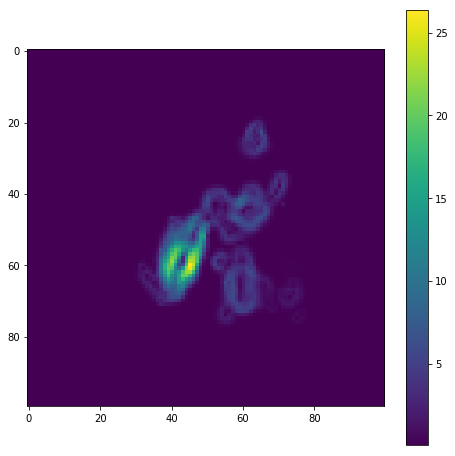

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(grad1)
plt.colorbar()
print("Max gradient:", grad1.max())

### Gradient numerically approximated

In [25]:
varargs = [1./elm01.dims[0], elm01.dims[1]]

In [26]:
ux, uy = np.gradient(u, varargs)

ValueError: distances must be scalars

In [24]:
u = elm01.get_approximation()
#varargs = [1./elm01.dims[0], elm01.dims[1]]
grad2 = gradient(u)

Max gradient 0.241080945922


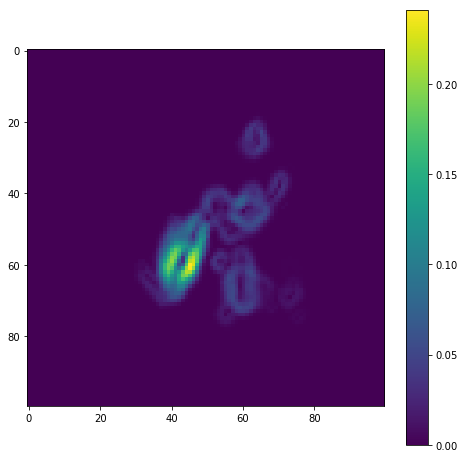

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(grad2)
plt.colorbar()
print("Max gradient",grad2.max())

### Captures the same shape, but there are differences in the scale!